# Aula 38 - árvores, validação e poda

In [ ]:
# === Utilitarios mínimos (acurácia, dataset de exemplo e plot) ===
import numpy as np
import matplotlib.pyplot as plt

def accuracy(y_true, y_pred):
    return float((y_true == y_pred).mean())

# Nova em relação a 1
def confusion_matrix(y_true, y_pred, n_classes=None):
    if n_classes is None:
        n_classes = int(max(y_true.max(), y_pred.max())) + 1
    M = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        M[int(t), int(p)] += 1
    return M

def make_moons(n=600, noise=0.25, seed=0):
    rng = np.random.RandomState(seed)
    angles = rng.rand(n//2) * np.pi*1.5
    x1 = np.c_[np.cos(angles), np.sin(angles)]
    x2 = x1 + [1.0, -0.5]  #np.c_[np.cos(angles), -np.sin(angles)]+[1.0, -0.5]#
    X = np.vstack([x1, x2])
    y = np.r_[np.zeros(n//2, dtype=int), np.ones(n//2, dtype=int)]
    X += rng.normal(scale=noise, size=X.shape)
    return X, y

def plot_decision_boundary(model, X, y, h=0.03, proba=False, title="Fronteira de decisão"):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    if proba and hasattr(model, "predict_proba"):
        Z = model.predict_proba(grid)
        if Z.ndim == 2 and Z.shape[1] > 1: Z = Z[:,1]
    else:
        Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k')
    plt.title(title); plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()

# Nova em relação a 1 - split para treino
def train_test_split(X, y, test_size=0.3, seed=0, stratify=True):
    rng = np.random.RandomState(seed)
    n = X.shape[0]
    idx = np.arange(n)
    if stratify:
        # estratificação estilo as que fizemos nos casos multiclasse anteriores
        idx_tr = []
        idx_te = []
        for c in np.unique(y):
            ii = np.where(y == c)[0]
            rng.shuffle(ii)
            t = int(round((1 - test_size) * len(ii)))
            idx_tr.append(ii[:t]); idx_te.append(ii[t:])
        idx_tr = np.concatenate(idx_tr); idx_te = np.concatenate(idx_te)
    else:
        rng.shuffle(idx)
        t = int(round((1 - test_size) * n))
        idx_tr, idx_te = idx[:t], idx[t:]
    return X[idx_tr], X[idx_te], y[idx_tr], y[idx_te]

# Nova em relação a 1 - split de validação
def kfold_indices(n, k=5, shuffle=True, seed=0):
    rng = np.random.RandomState(seed)
    idx = np.arange(n)
    if shuffle:
        rng.shuffle(idx)
    folds = np.array_split(idx, k)
    for i in range(k):
        va = folds[i]
        tr = np.concatenate([folds[j] for j in range(k) if j != i])
        yield tr, va

# Nova em relação a 1 - plotzinho simples
def plot_lines(xs, ys_dict, xlabel="", ylabel="", title=""):
    plt.figure()
    for label, ys in ys_dict.items():
        plt.plot(xs, ys, marker="o", label=label)
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()


In [ ]:
# igual ao 1
import numpy as np

def class_probs(y, n_classes=None):
    y = y.astype(int)
    if n_classes is None:
        if y.size == 0:
            return np.array([])
        n_classes = int(np.max(y)) + 1
    counts = np.bincount(y, minlength=n_classes).astype(float)
    s = counts.sum()
    return counts / s if s > 0 else counts

def gini(y):
    p = class_probs(y); return 1.0 - np.sum(p**2)

def entropy(y, eps=1e-12):
    p = class_probs(y); return -np.sum(p * np.log(p + eps))

def impurity(y, criterion="gini"):
    return gini(y) if criterion == "gini" else entropy(y)

def candidate_thresholds(x, max_candidates=50):
    x = np.asarray(x); uniq = np.unique(x)
    if uniq.size < 2: return np.array([])
    if uniq.size > max_candidates:
        qs = np.linspace(0, 1, max_candidates + 2)[1:-1]
        thr = np.unique(np.quantile(x, qs))
    else:
        thr = (uniq[:-1] + uniq[1:]) / 2.0
    return thr

def split_on_threshold(X, y, j, thr):
    xj = X[:, j]
    L = xj <= thr
    R = ~L
    return L, R

def weighted_impurity(yL, yR, criterion="gini"):
    m = yL.size + yR.size
    if m == 0: return 0.0
    return (yL.size * impurity(yL, criterion) + yR.size * impurity(yR, criterion)) / m

def best_split(X, y, *, criterion="gini", max_features=None, rng=None, max_candidates=50, stats=None):
    m, n = X.shape
    parent = impurity(y, criterion)
    if m == 0 or parent <= 0.0:
        return {"gain": 0.0, "feat": None, "thr": None}

    feats = np.arange(n)
    if max_features is not None:
        if isinstance(max_features, str) and max_features == "sqrt":
            k = max(1, int(np.sqrt(n)))
        elif isinstance(max_features, int):
            k = max(1, min(n, max_features))
        else:
            k = n
        if rng is None: rng = np.random.RandomState(0)
        feats = rng.choice(n, size=k, replace=False)

    best = {"gain": 0.0, "feat": None, "thr": None}
    cands = 0; valid = 0
    for j in feats:
        thrs = candidate_thresholds(X[:, j], max_candidates=max_candidates)
        cands += thrs.size
        for t in thrs:
            L, R = split_on_threshold(X, y, j, t)
            if not L.any() or not R.any():
                continue
            valid += 1
            gain = parent - weighted_impurity(y[L], y[R], criterion)
            if gain > best["gain"]:
                best = {"gain": float(gain), "feat": int(j), "thr": float(t)}
    if stats is not None:
        stats['cands'] = stats.get('cands', 0) + int(cands)
        stats['valid'] = stats.get('valid', 0) + int(valid)
    return best

def _leaf(y, n_classes):
    return {"type": "leaf", "proba": class_probs(y, n_classes=n_classes)}

def build_tree(X, y, depth, *, max_depth=8, min_samples_split=2,
               criterion="gini", max_features=None, rng=None, max_candidates=50, stats=None, n_classes=None):
    # Ensurse an effing fixed class dimension for the whole tree
    if n_classes is None:
        n_classes = int(np.max(y)) + 1 if y.size else 0

    if (depth >= max_depth) or (X.shape[0] < min_samples_split) or (impurity(y, criterion) == 0.0):
        return _leaf(y, n_classes)

    split = best_split(X, y, criterion=criterion, max_features=max_features, rng=rng,
                       max_candidates=max_candidates, stats=stats)
    if split["feat"] is None:
        return _leaf(y, n_classes)

    j, t = split["feat"], split["thr"]
    L, R = split_on_threshold(X, y, j, t)
    left = build_tree(X[L], y[L], depth+1, max_depth=max_depth, min_samples_split=min_samples_split,
                      criterion=criterion, max_features=max_features, rng=rng,
                      max_candidates=max_candidates, stats=stats, n_classes=n_classes)
    right = build_tree(X[R], y[R], depth+1, max_depth=max_depth, min_samples_split=min_samples_split,
                       criterion=criterion, max_features=max_features, rng=rng,
                       max_candidates=max_candidates, stats=stats, n_classes=n_classes)
    return {"type": "node", "feat": int(j), "thr": float(t), "left": left, "right": right}

def predict_proba_row(node, x):
    while node["type"] != "leaf":
        node = node["left"] if x[node["feat"]] <= node["thr"] else node["right"]
    return node["proba"]

def predict_proba(tree, X):
    return np.vstack([predict_proba_row(tree, x) for x in X])

def predict(tree, X):
    P = predict_proba(tree, X); return np.argmax(P, axis=1)

class DecisionTree:
    def __init__(self, max_depth=8, min_samples_split=2, criterion="gini",
                 max_features=None, random_state=0, max_candidates=50):
        self.max_depth = max_depth; self.min_samples_split = min_samples_split
        self.criterion = criterion; self.max_features = max_features
        self.random_state = random_state; self.max_candidates = max_candidates
        self.rng_ = np.random.RandomState(random_state); self.tree_ = None
        self.n_classes_ = None
        self.stats_ = {}

    def fit(self, X, y):
        self.n_classes_ = int(np.max(y)) + 1 if y.size else 0
        self.stats_ = {}
        self.tree_ = build_tree(
            X, y, depth=0,
            max_depth=self.max_depth, min_samples_split=self.min_samples_split,
            criterion=self.criterion, max_features=self.max_features, rng=self.rng_,
            max_candidates=self.max_candidates, stats=self.stats_, n_classes=self.n_classes_
        )
        return self

    def predict_proba(self, X): return predict_proba(self.tree_, X)
    def predict(self, X): return np.argmax(self.predict_proba(X), axis=1)

def trace_path(tree, x):
    steps = []; node = tree
    while node["type"] != "leaf":
        j, t = node["feat"], node["thr"]; go_left = x[j] <= t
        steps.append((int(j), float(t), bool(go_left)))
        node = node["left"] if go_left else node["right"]
    return steps, node["proba"]

def pretty_print(node, depth=0):
    import numpy as _np
    indent = "  " * depth
    if node["type"] == "leaf":
        print(f"{indent}Leaf proba={_np.round(node['proba'], 3)}")
    else:
        j, t = node["feat"], node["thr"]
        print(f"{indent}if x[{j}] <= {t:.4f}:")
        pretty_print(node["left"], depth+1)
        print(f"{indent}else:  # x[{j}] > {t:.4f}")
        pretty_print(node["right"], depth+1)

Melhor max_depth (val): 3 | Acurácia val: 0.8464


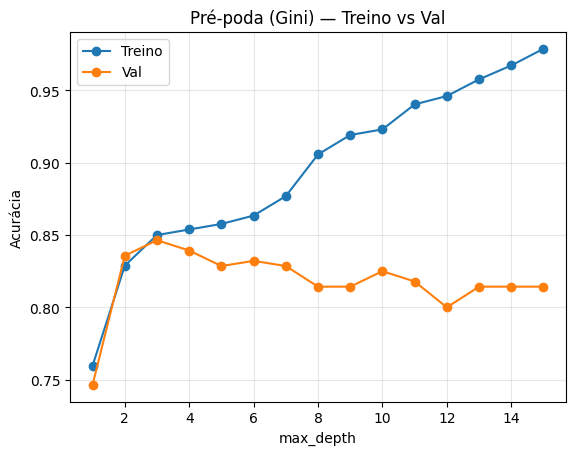

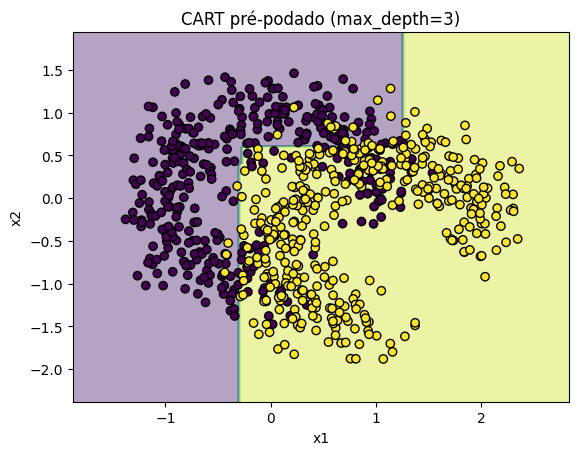

In [ ]:
# === pre-pruning via validação e curvas de aprendizado ===
X, y = make_moons(n=800, noise=0.25, seed=42)
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.35, seed=1, stratify=True)

def eval_depth(depths, criterion="gini", seed=0):
    acc_tr, acc_va = [], []
    for d in depths:
        model = DecisionTree(max_depth=d, min_samples_split=2, criterion=criterion, random_state=seed).fit(Xtr, ytr)
        acc_tr.append(accuracy(ytr, model.predict(Xtr)))
        acc_va.append(accuracy(yva, model.predict(Xva)))
    return np.array(acc_tr), np.array(acc_va)

depths = list(range(1, 16))
acc_tr, acc_va = eval_depth(depths, criterion="gini", seed=0)
best_d = depths[int(np.argmax(acc_va))]
print("Melhor max_depth (val):", best_d, "| Acurácia val:", round(float(np.max(acc_va)), 4))

plot_lines(depths, {"Treino": acc_tr, "Val": acc_va},
           xlabel="max_depth", ylabel="Acurácia", title="Pré-poda (Gini) — Treino vs Val")

# Treine o modelo final com a melhor profundidade e visualize
best = DecisionTree(max_depth=best_d, criterion="gini", random_state=0).fit(Xtr, ytr)
plot_decision_boundary(best, X, y, title=f"CART pré-podado (max_depth={best_d})")


Árvore profunda — Acurácia Val (antes): 0.7886
Pós-podada — Acurácia Val (depois): 0.8686


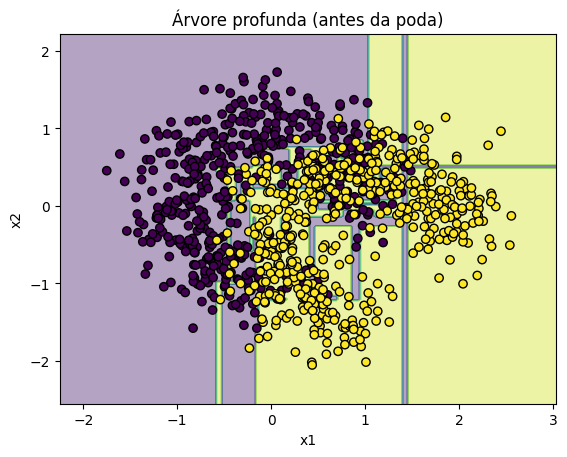

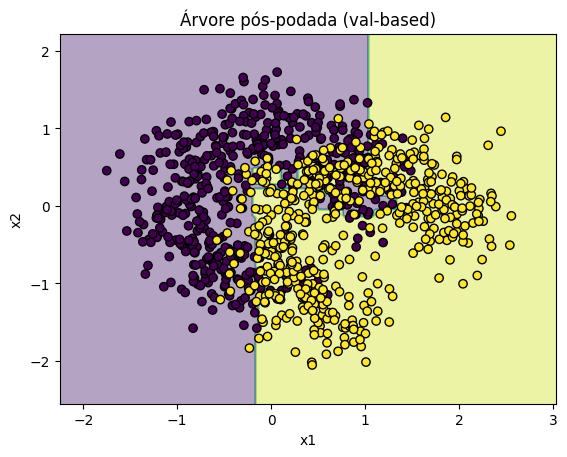

In [ ]:
# === pós-poda por validação (ganho de generalização) ===
from copy import deepcopy

def predict_dict_tree(tree, X):
    return predict(tree, X)

def _iter_internal_nodes(node):
    if node["type"] == "leaf":
        return
    yield node
    yield from _iter_internal_nodes(node["left"])
    yield from _iter_internal_nodes(node["right"])

def _mask_at_node(root, target_node, X):

    m = X.shape[0]
    mask = np.zeros(m, dtype=bool)
    for i in range(m):
        node = root
        while node["type"] != "leaf":
            if node is target_node:
                mask[i] = True
                break
            j, t = node["feat"], node["thr"]
            node = node["left"] if X[i, j] <= t else node["right"]
        if node is target_node:
            mask[i] = True
    return mask

def prune_tree_validation(root, X_tr, y_tr, X_val, y_val, n_classes=None):
    if n_classes is None:
        n_classes = int(max(y_tr.max(), y_val.max())) + 1
    improved = True
    while improved:
        base_acc = accuracy(y_val, predict_dict_tree(root, X_val))
        best_gain = 0.0
        best_node = None
        best_leaf_proba = None

        for node in _iter_internal_nodes(root):
            mask_tr = _mask_at_node(root, node, X_tr)
            if not mask_tr.any():
                continue

            leaf_proba = class_probs(y_tr[mask_tr], n_classes=n_classes)

            #temppoda
            backup = dict(node)
            node.clear(); node.update({"type": "leaf", "proba": leaf_proba})
            acc = accuracy(y_val, predict_dict_tree(root, X_val))

            node.clear(); node.update(backup)

            gain = acc - base_acc
            if gain >= 0 and gain > best_gain + 1e-12:
                best_gain = gain
                best_node = node
                best_leaf_proba = leaf_proba

        if best_node is not None:
            best_node.clear(); best_node.update({"type": "leaf", "proba": best_leaf_proba})
            improved = True
        else:
            improved = False
    return root


X, y = make_moons(n=1000, noise=0.30, seed=42)
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.35, seed=1, stratify=True)


# Compare: árvore profunda (overfit) vs pós-podada
deep = DecisionTree(max_depth=30, criterion="gini", random_state=0).fit(Xtr, ytr)
tree_to_prune = deepcopy(deep.tree_)
base_val = accuracy(yva, deep.predict(Xva))
print("Árvore profunda — Acurácia Val (antes):", round(base_val, 4))

pruned_tree = prune_tree_validation(tree_to_prune, Xtr, ytr, Xva, yva, n_classes=2)
pruned_val = accuracy(yva, predict(pruned_tree, Xva))
print("Pós-podada — Acurácia Val (depois):", round(pruned_val, 4))

# tempwrapper
class _Wrapped:
    def __init__(self, tree): self.tree_ = tree
    def predict(self, X): return predict(self.tree_, X)
    def predict_proba(self, X): return predict_proba(self.tree_, X)

plot_decision_boundary(deep, X, y, title="Árvore profunda (antes da poda)")
plot_decision_boundary(_Wrapped(pruned_tree), X, y, title="Árvore pós-podada (val-based)")


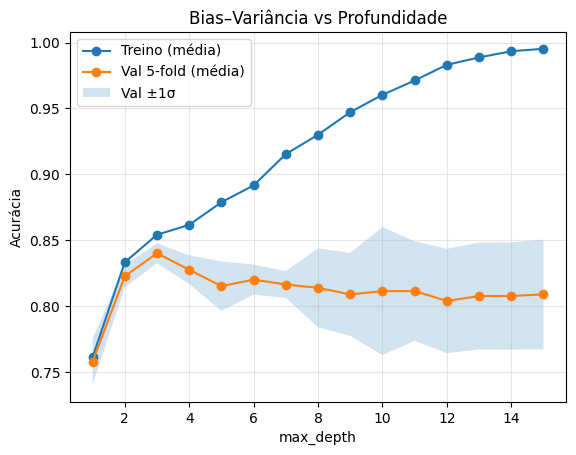

Profundidade que maximiza média Val: 3


In [ ]:
# === Bias–Variância com K-fold por profundidade ===
X, y = make_moons(n=800, noise=0.25, seed=7)

depths = list(range(1, 16))
k = 5
mean_tr, mean_va, std_va = [], [], []

for d in depths:
    tr_scores, va_scores = [], []
    for tr, va in kfold_indices(len(y), k=k, shuffle=True, seed=42):
        Xtr, Xva = X[tr], X[va]
        ytr, yva = y[tr], y[va]
        model = DecisionTree(max_depth=d, criterion="gini", random_state=0).fit(Xtr, ytr)
        tr_scores.append(accuracy(ytr, model.predict(Xtr)))
        va_scores.append(accuracy(yva, model.predict(Xva)))
    mean_tr.append(np.mean(tr_scores))
    mean_va.append(np.mean(va_scores))
    std_va.append(np.std(va_scores))

mean_tr = np.array(mean_tr); mean_va = np.array(mean_va); std_va = np.array(std_va)

plt.figure()
plt.plot(depths, mean_tr, marker="o", label="Treino (média)")
plt.plot(depths, mean_va, marker="o", label=f"Val {k}-fold (média)")
plt.fill_between(depths, mean_va - std_va, mean_va + std_va, alpha=0.2, label="Val ±1σ")
plt.xlabel("max_depth"); plt.ylabel("Acurácia"); plt.title("Bias–Variância vs Profundidade")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

best_d = depths[int(np.argmax(mean_va))]
print("Profundidade que maximiza média Val:", best_d)


# Exercícios

1. Olhando para o gráfico final ("Bias–Variância vs Profundidade"), quais valores de `max_depth` correspondem a alto viés (underfitting)?
Quais valores de `max_depth` correspondem a alta variância (overfitting)? O que a área sombreada (`±1σ`) representa e por que ela é útil?

2. Qual é a diferença fundamental entre a pré-poda (selecionar `max_depth` com um conjunto de validação) e a abordagem de pós-poda mostrada no notebook? Quais são os prós e contras de cada uma?

3. Modifique o código para analisar o efeito de `min_samples_split`. Mantenha `max_depth` fixo, teste uma gama de valores para `min_samples_split`, plote as curvas e analise o resultado.

4. Na seção "Bias–Variância com K-fold", mude o parâmetro `noise` na função `make_moons` de `0.25` para `0.40` e `0.60`. Como isso afeta o gráfico e o `max_depth` ótimo?

